### Changelog v5
- use batch normalization, no bias at conv <br>
- use preprocess_input
(from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input )
- output layer no batch norm
- use default mse again 
- change loss function
- improve data prerpocess
- from keras.initializers import RandomNormal 
### Changelog v8
- use adam

### Changelog v9
- reduce output density map by 1/8 

In [1]:
!python --version
!pip --version

Python 3.6.6 :: Anaconda, Inc.
pip 19.1.1 from /opt/conda/lib/python3.6/site-packages/pip (python 3.6)


In [3]:
import glob

In [4]:
print(os.listdir("../input/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data"))

['ground-truth-h5', 'ground-truth', 'images']


# Let's import thing first

## data loader

In [5]:
DATA_PATH = "../input/shanghaitech_with_people_density_map/ShanghaiTech/part_A/train_data"
TEST_PATH = "../input/shanghaitech_with_people_density_map/ShanghaiTech/part_A/test_data"
MODEL_PATH = "csrnet_shanghaitechA_task1.model"
MODEL_JSON_PATH = "csrnet_shanghaitechA_task1.json"

In [6]:
import os
from tqdm import tqdm
import glob
from sklearn.model_selection import train_test_split
import json
"""
create a list of file (full directory)
"""




def create_training_image_list(data_path):
    """
    create a list of absolutely path of jpg file
    :param data_path: must contain subfolder "images" with *.jpg  (example ShanghaiTech/part_A/train_data/)
    :return:
    """
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    return image_path_list


def get_train_val_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    train, val = train_test_split(image_path_list, test_size=0.1)

    print("train size ", len(train))
    print("val size ", len(val))
    return train, val

def get_test_list(data_path):
    DATA_PATH = data_path
    image_path_list = glob.glob(os.path.join(DATA_PATH, "images", "*.jpg"))
    
    print("test size ", len(image_path_list))
    return image_path_list

def create_density_path_list(image_path_list):
    gt_paths = []
    for img_path in image_path_list:
        gt_path = img_path.replace('.jpg','.h5').replace('images','ground-truth-h5')
        gt_paths.append(gt_path)
    return gt_paths

In [ ]:
# train_img_path, val_img_path = get_train_val_list(DATA_PATH)
# train_density_path = create_density_path_list(train_img_path)
# val_density_path = create_density_path_list(val_img_path)

In [ ]:
# DATA_PATH = "../input/ucfcrowdcountingdataset_cvpr13_with_people_density_map/UCF_CC_50/"
# MODEL_PATH = "single_image_random_crop_experiment_model_1.model"
# image_list = glob.glob(DATA_PATH+"*.jpg")
# density_list = list(map(lambda s: s.replace(".jpg", ".h5"), image_list))

In [7]:
from tensorflow.python.keras import backend as K
def mae_metric(y_true, y_pred):
    return K.abs(K.sum(y_true) - K.sum(y_pred))

In [8]:
from tensorflow.python.keras import backend as K
def euclidean_distance_loss(y_true, y_pred):
    """
    # Euclidean distance as a measure of loss (Loss function) 
    copy from https://github.com/Neerajj9/CSRNet-keras/blob/master/Model.ipynb
    """
    return K.sqrt(K.sum(K.sum(K.sum(K.square(y_pred - y_true), axis=3), axis=2), axis=1))
#     x = K.square(y_pred - y_true)
#     batch_size, w, h, channel_size = x.shape
#     x = K.reshape(x, (batch_size, w*h*channel_size))
#     return K.sqrt(K.sum(x, axis=-1))

In [9]:
# from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.models import load_model, model_from_json
from tensorflow.python.keras.applications.vgg16 import VGG16, preprocess_input
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.python.keras.losses import mean_squared_error


from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Conv2D, UpSampling2D, BatchNormalization, Activation

from tensorflow.python.keras.initializers import RandomNormal 
import numpy as np

from tensorflow.python.keras.optimizers import SGD, Adam
# from keras import optimizers


def build_model():
    sgd = SGD(lr=1e-7, decay=5*1e-4, momentum=0.95)
    adam = Adam()
    vgg16_model = VGG16(weights='imagenet', include_top=False)
    # model = Model(inputs=base_model.input, outputs=base_model.get_layer('block4_pool').output)
    x = vgg16_model.get_layer('block4_conv3').output
    x = BatchNormalization()(x)
#     x = UpSampling2D(size=(8, 8))(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=512, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=256, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=128, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=64, kernel_size=(3, 3), dilation_rate=2, padding='same', use_bias=False, kernel_initializer=RandomNormal(stddev=0.01))(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters=1, kernel_size=(1, 1), dilation_rate=1, padding='same', use_bias=True, kernel_initializer=RandomNormal(stddev=0.01))(x)
#     x = BatchNormalization()(x)
    x = Activation('relu')(x)
    model = Model(inputs=vgg16_model.input, outputs=x)
    model.compile(optimizer=adam,
                  loss=mean_squared_error, metrics=[mae_metric])
    return model

In [10]:
def save_model(model , weight_path , json_path):
    """
    save model and json file
    source = https://github.com/Neerajj9/CSRNet-keras/blob/master/Model.ipynb
    """
    model.save_weights(weight_path)
    
    model_json = model.to_json()
    
    with open(json_path, "w") as json_file:
        json_file.write(model_json)

In [44]:
# Save the entire model to a HDF5 file
model.save('my_model.hdf5')

# Load the entire model from the HDF5 file
model = load_model('my_model.hdf5')

In [11]:
def load_json_model(weight_path, json_path):
    """
    load model and json file
    source = https://github.com/Neerajj9/CSRNet-keras/blob/master/Model.ipynb
    """
    # Function to load and return neural network model 
    json_file = open(json_path, 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(weight_path)
    return loaded_model

In [12]:
model = build_model()
model.save(MODEL_PATH)

58892288/58889256 [==============================] - 3s 0us/step


In [13]:
x = np.random.rand(1, 224, 224, 3)
pred = model.predict(x)
print(pred.shape)

(1, 28, 28, 1)


In [14]:
import cv2

In [15]:
# # TODO: write keras.utils.Sequence() to load image
# from tensorflow.python.keras.utils import Sequence

# import numpy as np
# import h5py
# import PIL.Image as Image


# def load_density(file_path):
#     gt_file = h5py.File(file_path, 'r')
#     groundtruth = np.asarray(gt_file['density'])
#     return groundtruth


# def random_crop(img, density_map, random_crop_size):
#     """
#     adapt from https://jkjung-avt.github.io/keras-image-cropping/
#     :param img: image matrix (h, w, channel)
#     :param density_map: (h, w, channel)
#     :param random_crop_size: h_crop, w_crop
#     :return:
#     """
#     # Note: image_data_format is 'channel_last'
#     assert img.shape[2] == 3
#     height, width = img.shape[0], img.shape[1]
#     dy, dx = random_crop_size
#     x = np.random.randint(0, width - dx + 1)
#     y = np.random.randint(0, height - dy + 1)

#     return img[y:(y+dy), x:(x+dx), :], density_map[y:(y+dy), x:(x+dx), :]


# TODO: write keras.utils.Sequence() to load image
from tensorflow.python.keras.utils import Sequence

import numpy as np
import h5py
import PIL.Image as Image


def load_density(file_path):
    gt_file = h5py.File(file_path, 'r')
    groundtruth = np.asarray(gt_file['density'])
    return groundtruth

def downsample_density_map(density):
    density2 = density.squeeze(3).squeeze(0)
    density3 = cv2.resize(density2,(int(density2.shape[1]/8), int(density2.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
    density4 = np.expand_dims(density3, axis=0)
    density5 = np.expand_dims(density4, axis=3)
    return density5
    

def random_crop(img, density_map, random_crop_size):
    """
    adapt from https://jkjung-avt.github.io/keras-image-cropping/
    :param img: image matrix (h, w, channel)
    :param density_map: (h, w, channel)
    :param random_crop_size: h_crop, w_crop
    :return:
    """
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    # print("x shape ", x.shape)
    # print("img shape ", img.shape)
    # print("density shape ", density_map.shape)
    return img[y:(y+dy), x:(x+dx), :], density_map[y:(y+dy), x:(x+dx), :]


class DatasetSequence(Sequence):

    def __init__(self, image_path_list, density_path_list, random_crop_size=None, same_size_density=True):
        self.image_path_list = image_path_list
        self.density_path_list = density_path_list
        self.random_crop_size = random_crop_size
        self.batch_size = 1
        self.same_size_density = same_size_density
        
    def __len__(self):
        return len(self.image_path_list)

    def __getitem__(self, idx):
        try:
            image_path = self.image_path_list[idx]
            density_path = self.density_path_list[idx]

            density = load_density(density_path)
            image = np.array(Image.open(image_path, "r").convert("RGB"))
            density = np.expand_dims(density, axis=3)  # add channel dim

            if self.random_crop_size is not None:
                # print("crop ", self.random_crop_size)
                image, density = random_crop(image, density, self.random_crop_size)        
    
            # preprocess vgg16 input
            im = image
            im = im/255.0
            im[:,:,0]=(im[:,:,0]-0.485)/0.229
            im[:,:,1]=(im[:,:,1]-0.456)/0.224
            im[:,:,2]=(im[:,:,2]-0.406)/0.225
            image = im

            # density = np.expand_dims(density, axis=3)  # add channel dim
            image = np.expand_dims(image, axis=0) # add batch dim
            density = np.expand_dims(density, axis=0) # add batch dim
            
            if not self.same_size_density:
                density = downsample_density_map(density)

            return image, density
        except:
            pass
        
    def get_non_preprocess(self, idx):
        try:
            image_path = self.image_path_list[idx]
            density_path = self.density_path_list[idx]

            density = load_density(density_path)
            image = np.array(Image.open(image_path, "r").convert("RGB"))
            density = np.expand_dims(density, axis=3)  # add channel dim
                
            # density = np.expand_dims(density, axis=3)  # add channel dim
            image = np.expand_dims(image, axis=0) # add batch dim
            density = np.expand_dims(density, axis=0) # add batch dim

            return image, density
        except:
            pass

    def get_random_crop_image(self, idx):
#         try:
        image_path = self.image_path_list[idx]
        density_path = self.density_path_list[idx]

        density = load_density(density_path)
        image = np.array(Image.open(image_path, "r").convert("RGB"))
        density = np.expand_dims(density, axis=3)  # add channel dim

        if self.random_crop_size is not None:
            # print("crop ", self.random_crop_size)
            image, density = random_crop(image, density, self.random_crop_size)
            
        # preprocess vgg16 input
        im = image
        im = im/255.0
        im[:,:,0]=(im[:,:,0]-0.485)/0.229
        im[:,:,1]=(im[:,:,1]-0.456)/0.224
        im[:,:,2]=(im[:,:,2]-0.406)/0.225
        image = im

        image = np.expand_dims(image, axis=0)  # add batch dim
        density = np.expand_dims(density, axis=0)  # add batch dim
#         except:
#             print("get_random_crop_image ", idx)
#             print("img path = ", image_path)
#             print("img shape ", image.shape)
#             print("density shape ", density.shape)
        return image, density

    def get_random_crop_image_batch(self, idx, batch_size):
        image_batch = []
        density_batch = []
        
        for i in range(batch_size):
            image, density = self.get_random_crop_image(idx)
            image_batch.append(image)
            density_batch.append(density)

        images = np.concatenate(image_batch, axis=0)
        densities = np.concatenate(density_batch, axis=0)
        return images, densities
    
    def get_all(self, crop_per_img):
        image_list = []
        density_list = []
        for i in tqdm(range(len(self.image_path_list))):
            try:
                image, density = self.get_random_crop_image_batch(i, crop_per_img)
                image_list.append(image)
                density_list.append(density)
            except:
                print("exception at image ", i)
        image_mat = np.concatenate(image_list, axis = 0)
        density_mat = np.concatenate(density_list, axis = 0)
        return image_mat, density_mat



In [16]:
train_img_path, val_img_path = get_train_val_list(DATA_PATH)
train_density_path = create_density_path_list(train_img_path)
val_density_path = create_density_path_list(val_img_path)

train size  270
val size  30


In [17]:
train_dataset = DatasetSequence(train_img_path, train_density_path, random_crop_size=(224, 224), same_size_density=False)

In [18]:
img, density = train_dataset[0]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:93: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [19]:
density.shape

(1, 28, 28, 1)

In [20]:
density2 = density.squeeze(3).squeeze(0)
density3 = cv2.resize(density2,(int(density2.shape[1]/8), int(density2.shape[0]/8)),interpolation = cv2.INTER_CUBIC)*64
density4 = np.expand_dims(density3, axis=0)
density5 = np.expand_dims(density4, axis=3)
print(density3.shape)
print(density2.shape)
print(density5.shape)

(3, 3)
(28, 28)
(1, 3, 3, 1)


In [21]:
# density2 = cv2.resize(density,(1, int(density.shape[1]/8), int(density.shape[2]/8), 1),interpolation = cv2.INTER_CUBIC)*64


In [ ]:
# # generate dataset
# img_mat, density_mat = train_dataset.get_all(9)
# # img_mat = preprocess_input(img_mat)
# print(img_mat.shape)
# print(density_mat.shape)

In [ ]:
# a = img_mat[1:3]
# b = density_mat[1:3]
# print(b.shape)
# print(a.shape)

In [ ]:
# bb = model.predict(a)
# print(bb.shape)

In [ ]:
# eu_loss = euclidean_distance_loss(b, bb)
# print(eu_loss.shape)
# mse_loss = mean_squared_error(b, bb)
# print(mse_loss)

In [ ]:
# density_mat.dtype

## Single Image data generator

In [22]:
# train_dataset_nocrop = DatasetSequence(train_img_path, train_density_path)
# image, density = train_dataset_nocrop[0]
# print(image.shape)
# print(density.shape)

In [ ]:
# def image_generator():
#     train_dataset_nocrop = DatasetSequence(train_img_path, train_density_path)
#     for image, density in train_dataset_nocrop:
#         yield image, density

In [ ]:
# print(img_mat.shape)
# print(density_mat.shape)

In [ ]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# # we create two instances with the same arguments
# data_gen_args = dict(rotation_range=90,
#                      width_shift_range=0.1,
#                      height_shift_range=0.1,
#                      zoom_range=0.2)
# image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)

# # Provide the same seed and keyword arguments to the fit and flow methods
# seed = 1
# image_datagen.fit(img_mat, augment=True, seed=seed)
# mask_datagen.fit(density_mat, augment=True, seed=seed)

# image_datagen.flow()

# # image_generator = image_datagen.flow_from_directory(
# #     'data/images',
# #     class_mode=None,
# #     seed=seed)

# # mask_generator = mask_datagen.flow_from_directory(
# #     'data/masks',
# #     class_mode=None,
# #     seed=seed)

# # combine generators into one which yields image and masks
# train_generator = zip(image_generator, mask_generator)

# Training

In [24]:
# dataset = DatasetSequence(image_list, density_list, random_crop_size=(224, 224))
model = build_model()

# for image, density in dataset:
#     model.fit(image, density)
epoch = 400
# n_sample = len(dataset)
print("total epoch ", epoch)
# print("sample ", n_sample)
# img_train, density_train = dataset.get_all(10)
model.fit_generator(train_dataset, shuffle=True, epochs = epoch)
save_model(model, MODEL_PATH, MODEL_JSON_PATH)
import sys
sys.stdout.flush()

total epoch  400


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:93: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


Epoch 1/400
270/270 [==============================] - 14s 51ms/step - loss: 0.0730 - mae_metric: 63.6152
Epoch 2/400
270/270 [==============================] - 11s 42ms/step - loss: 0.0572 - mae_metric: 57.5951
Epoch 3/400
270/270 [==============================] - 11s 42ms/step - loss: 0.0530 - mae_metric: 56.1280
Epoch 4/400
270/270 [==============================] - 11s 41ms/step - loss: 0.0641 - mae_metric: 57.4755
Epoch 5/400
270/270 [==============================] - 11s 42ms/step - loss: 0.0525 - mae_metric: 55.2694
Epoch 6/400
270/270 [==============================] - 12s 43ms/step - loss: 0.0424 - mae_metric: 48.3579
Epoch 7/400
270/270 [==============================] - 16s 59ms/step - loss: 0.0546 - mae_metric: 53.7576
Epoch 8/400
270/270 [==============================] - 11s 41ms/step - loss: 0.0474 - mae_metric: 51.4536
Epoch 9/400
270/270 [==============================] - 13s 47ms/step - loss: 0.0537 - mae_metric: 49.7632
Epoch 10/400
270/270 [========================

In [ ]:
# for img, density in train_dataset:
#     print(img.shape)
#     print(density.shape)
#     print("-----------------")

In [39]:
# Save the model architecture to a JSON file
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)


In [40]:
# Load the model architecture from the JSON file
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [41]:
# Save the model weights to a HDF5 file
model.save_weights('model_weights.hdf5')

# Load the model weights from the HDF5 file
loaded_model.load_weights('model_weights.hdf5')

# Evaluate

In [27]:
loaded_model = load_json_model(MODEL_PATH, MODEL_JSON_PATH)

In [30]:
import glob
import PIL.Image as Image
from matplotlib import pyplot as plt
from matplotlib import cm as CM
import os
import numpy as np


def save_density_map(density_map, name):
    plt.figure(dpi=600)
    plt.axis('off')
    plt.margins(0, 0)
    plt.imshow(density_map, cmap=CM.jet)
    plt.savefig(name, dpi=600, bbox_inches='tight', pad_inches=0)

In [45]:
# train_dataset
img_train, density_train = train_dataset.get_non_preprocess(0)
pil_img = Image.fromarray(img_train[0])

model = load_json_model(MODEL_PATH, MODEL_JSON_PATH)

print("label ", density_train.sum())

# img_train = preprocess_input(img_train)
pred = model.predict(img_train)
# pred = loaded_model.predict(img_train)

print("predict ", np.squeeze(pred[0], axis=2).shape, np.squeeze(pred[0], axis=2).sum())

print("------------")

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:125: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


label  260.8995
predict  (96, 128) 339.44427
------------


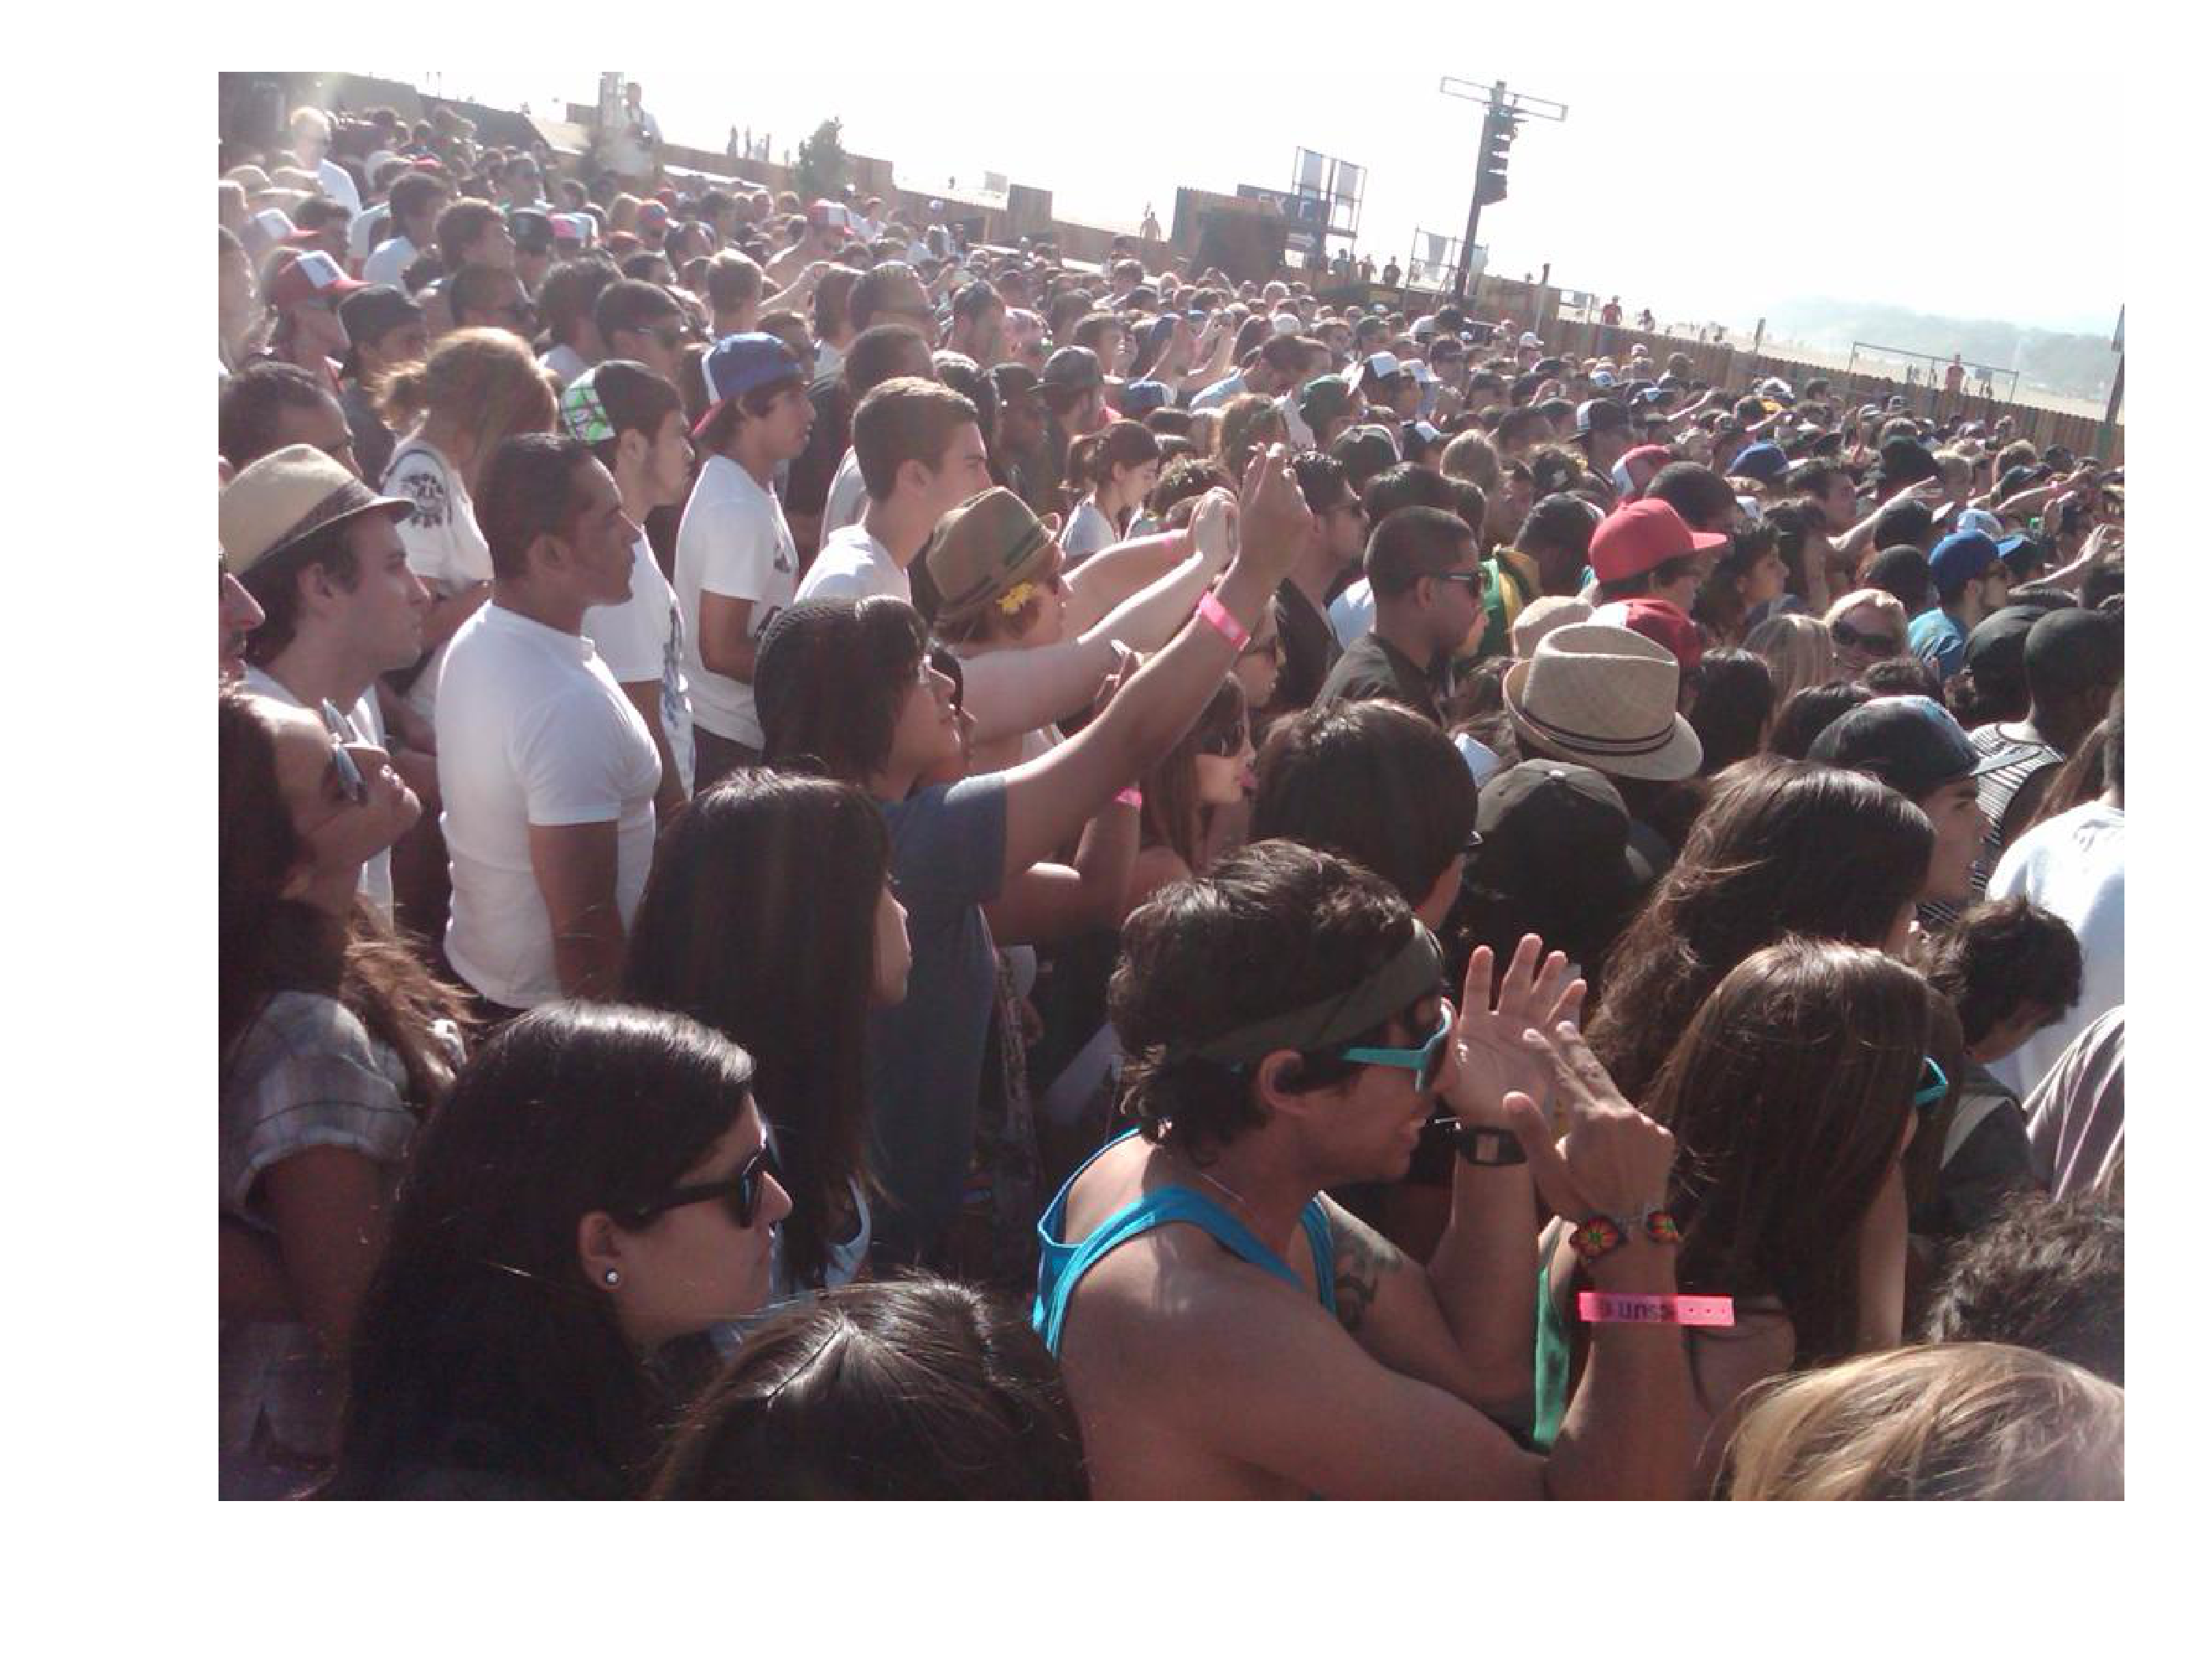

In [52]:
pil_img.save("train.png")
from matplotlib import pyplot as plt


plt.figure(dpi=600)
plt.axis('off')
plt.margins(0,0)
plt.imshow(Image.open("train.png"))

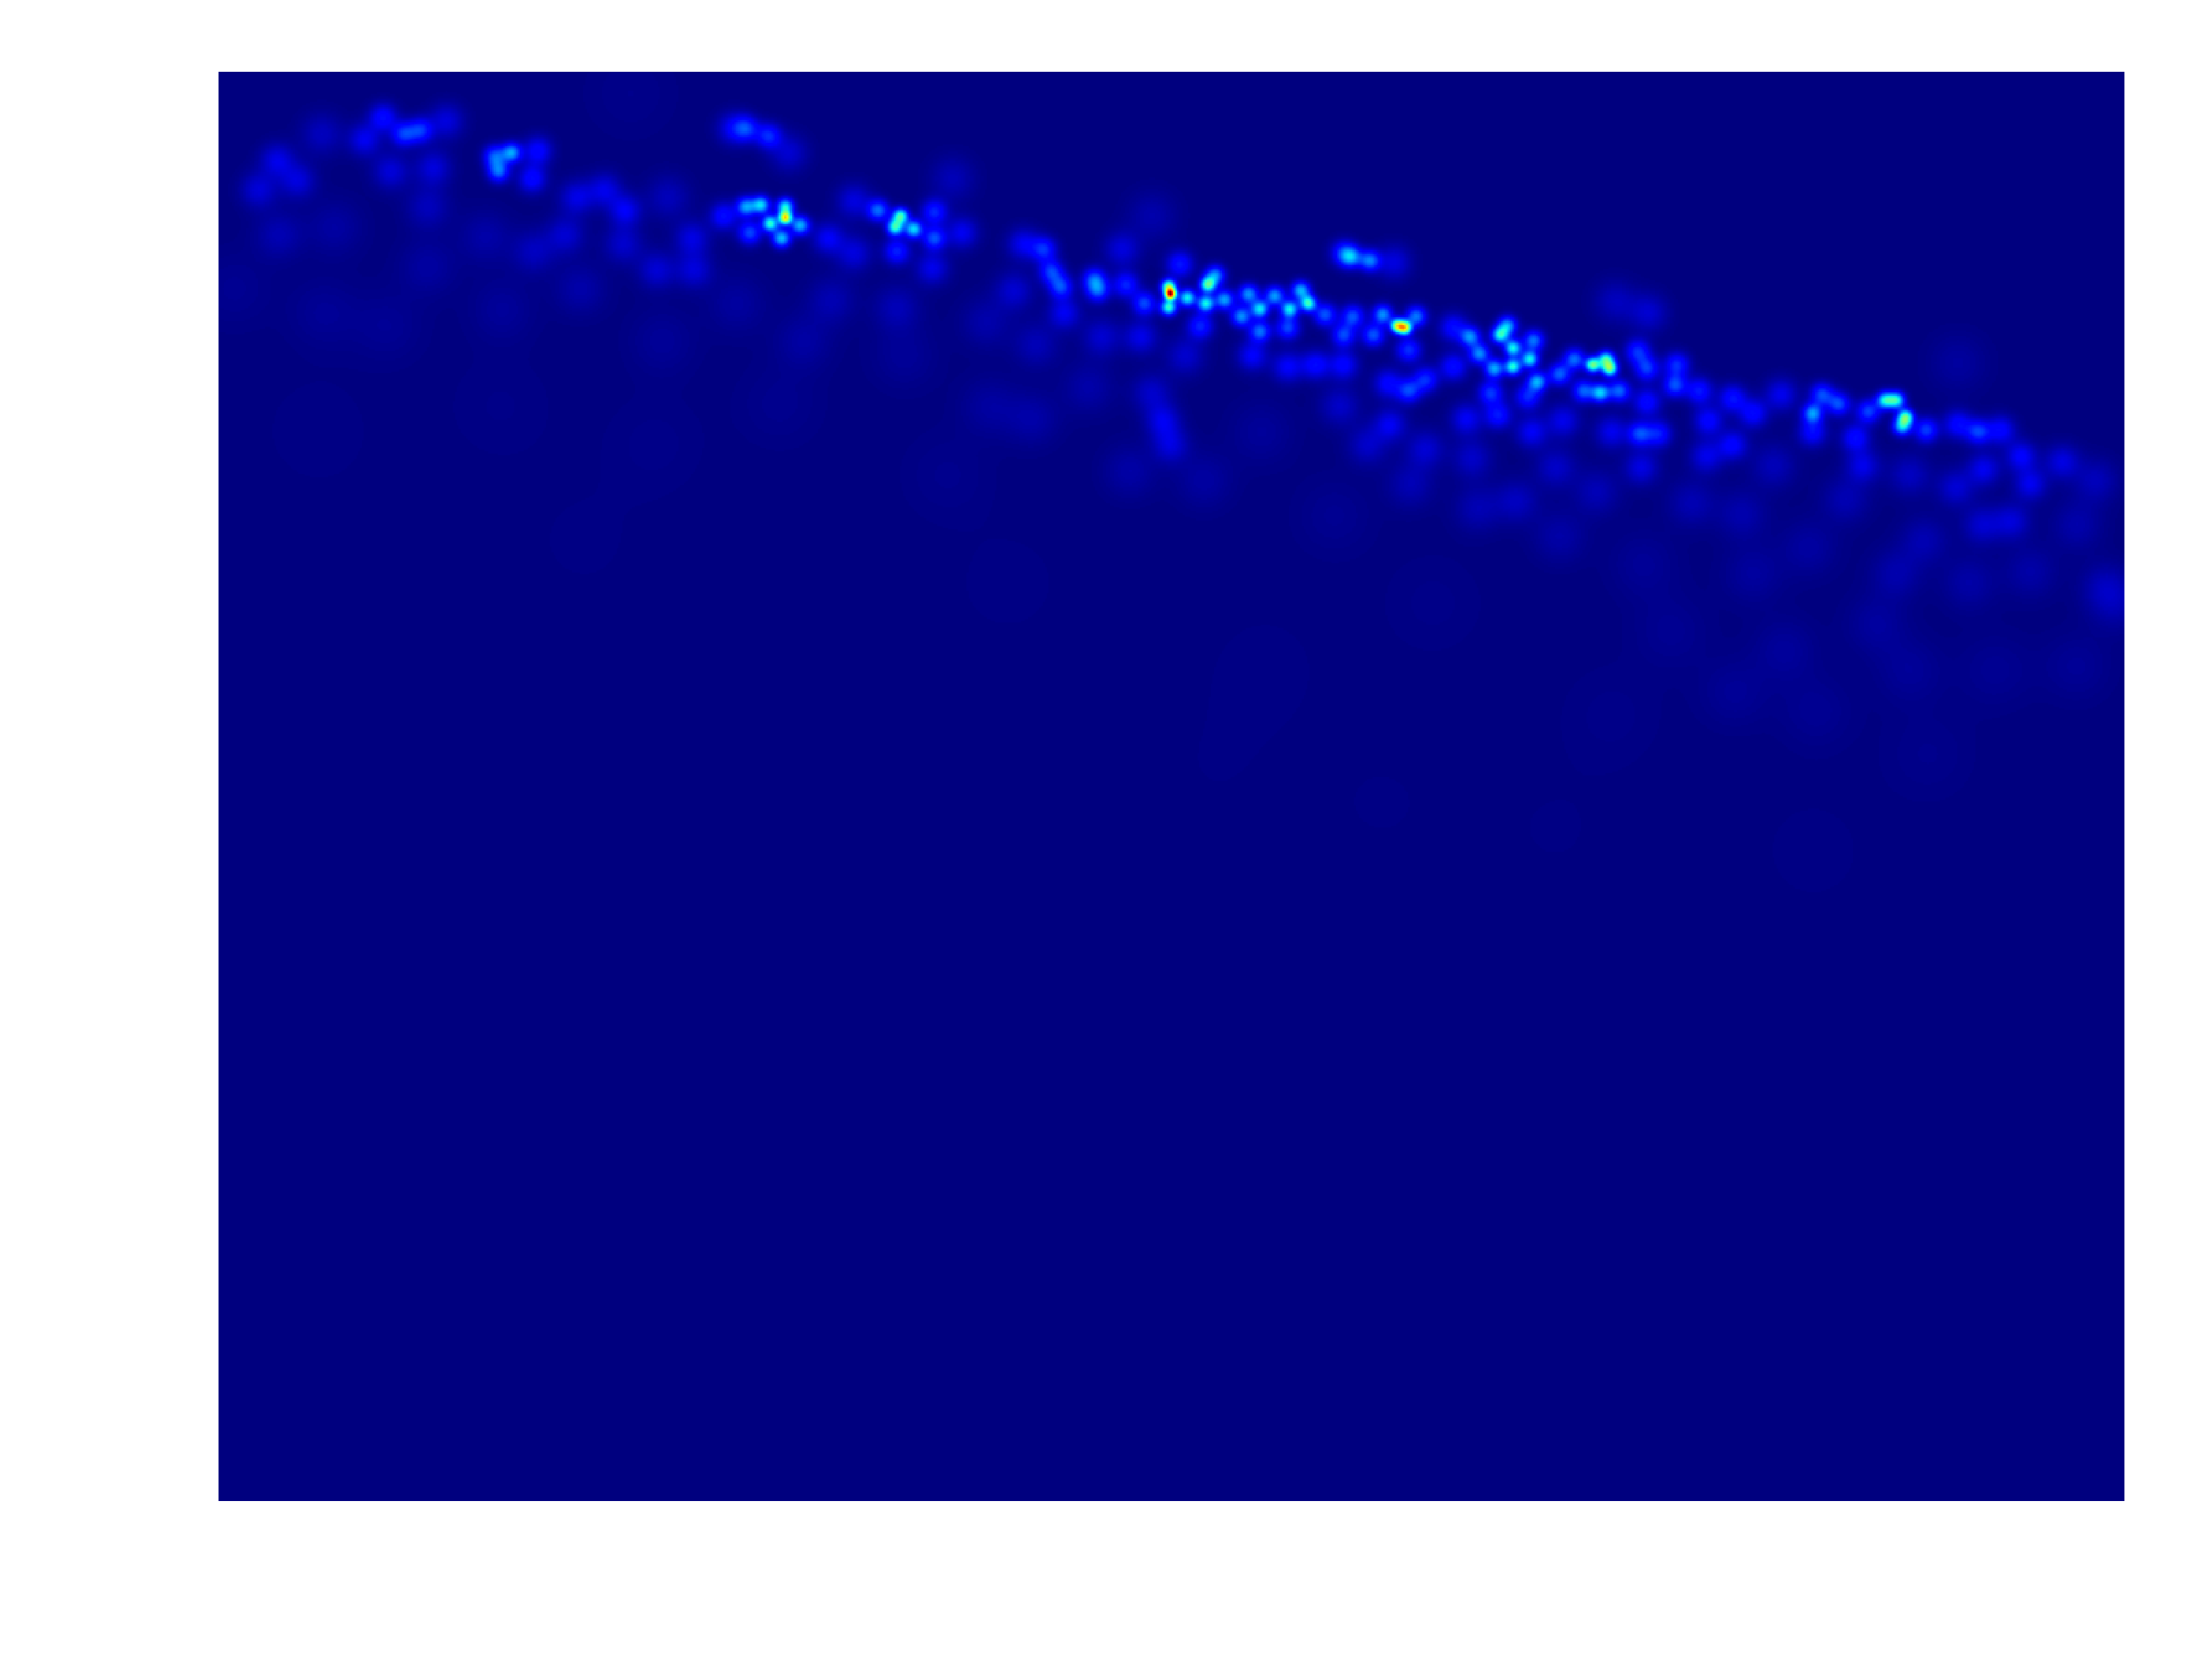

In [47]:
save_density_map(np.squeeze(density_train[0], axis=2), "label.png")

In [48]:
np.squeeze(pred[0], axis=2)

array([[0.11001064, 0.        , 0.        , ..., 0.        , 0.        ,
        0.07721891],
       [0.1937587 , 0.        , 0.02990216, ..., 0.        , 0.05865662,
        0.26900417],
       [0.04483571, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.29999602],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.41993088],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.42268157]], dtype=float32)

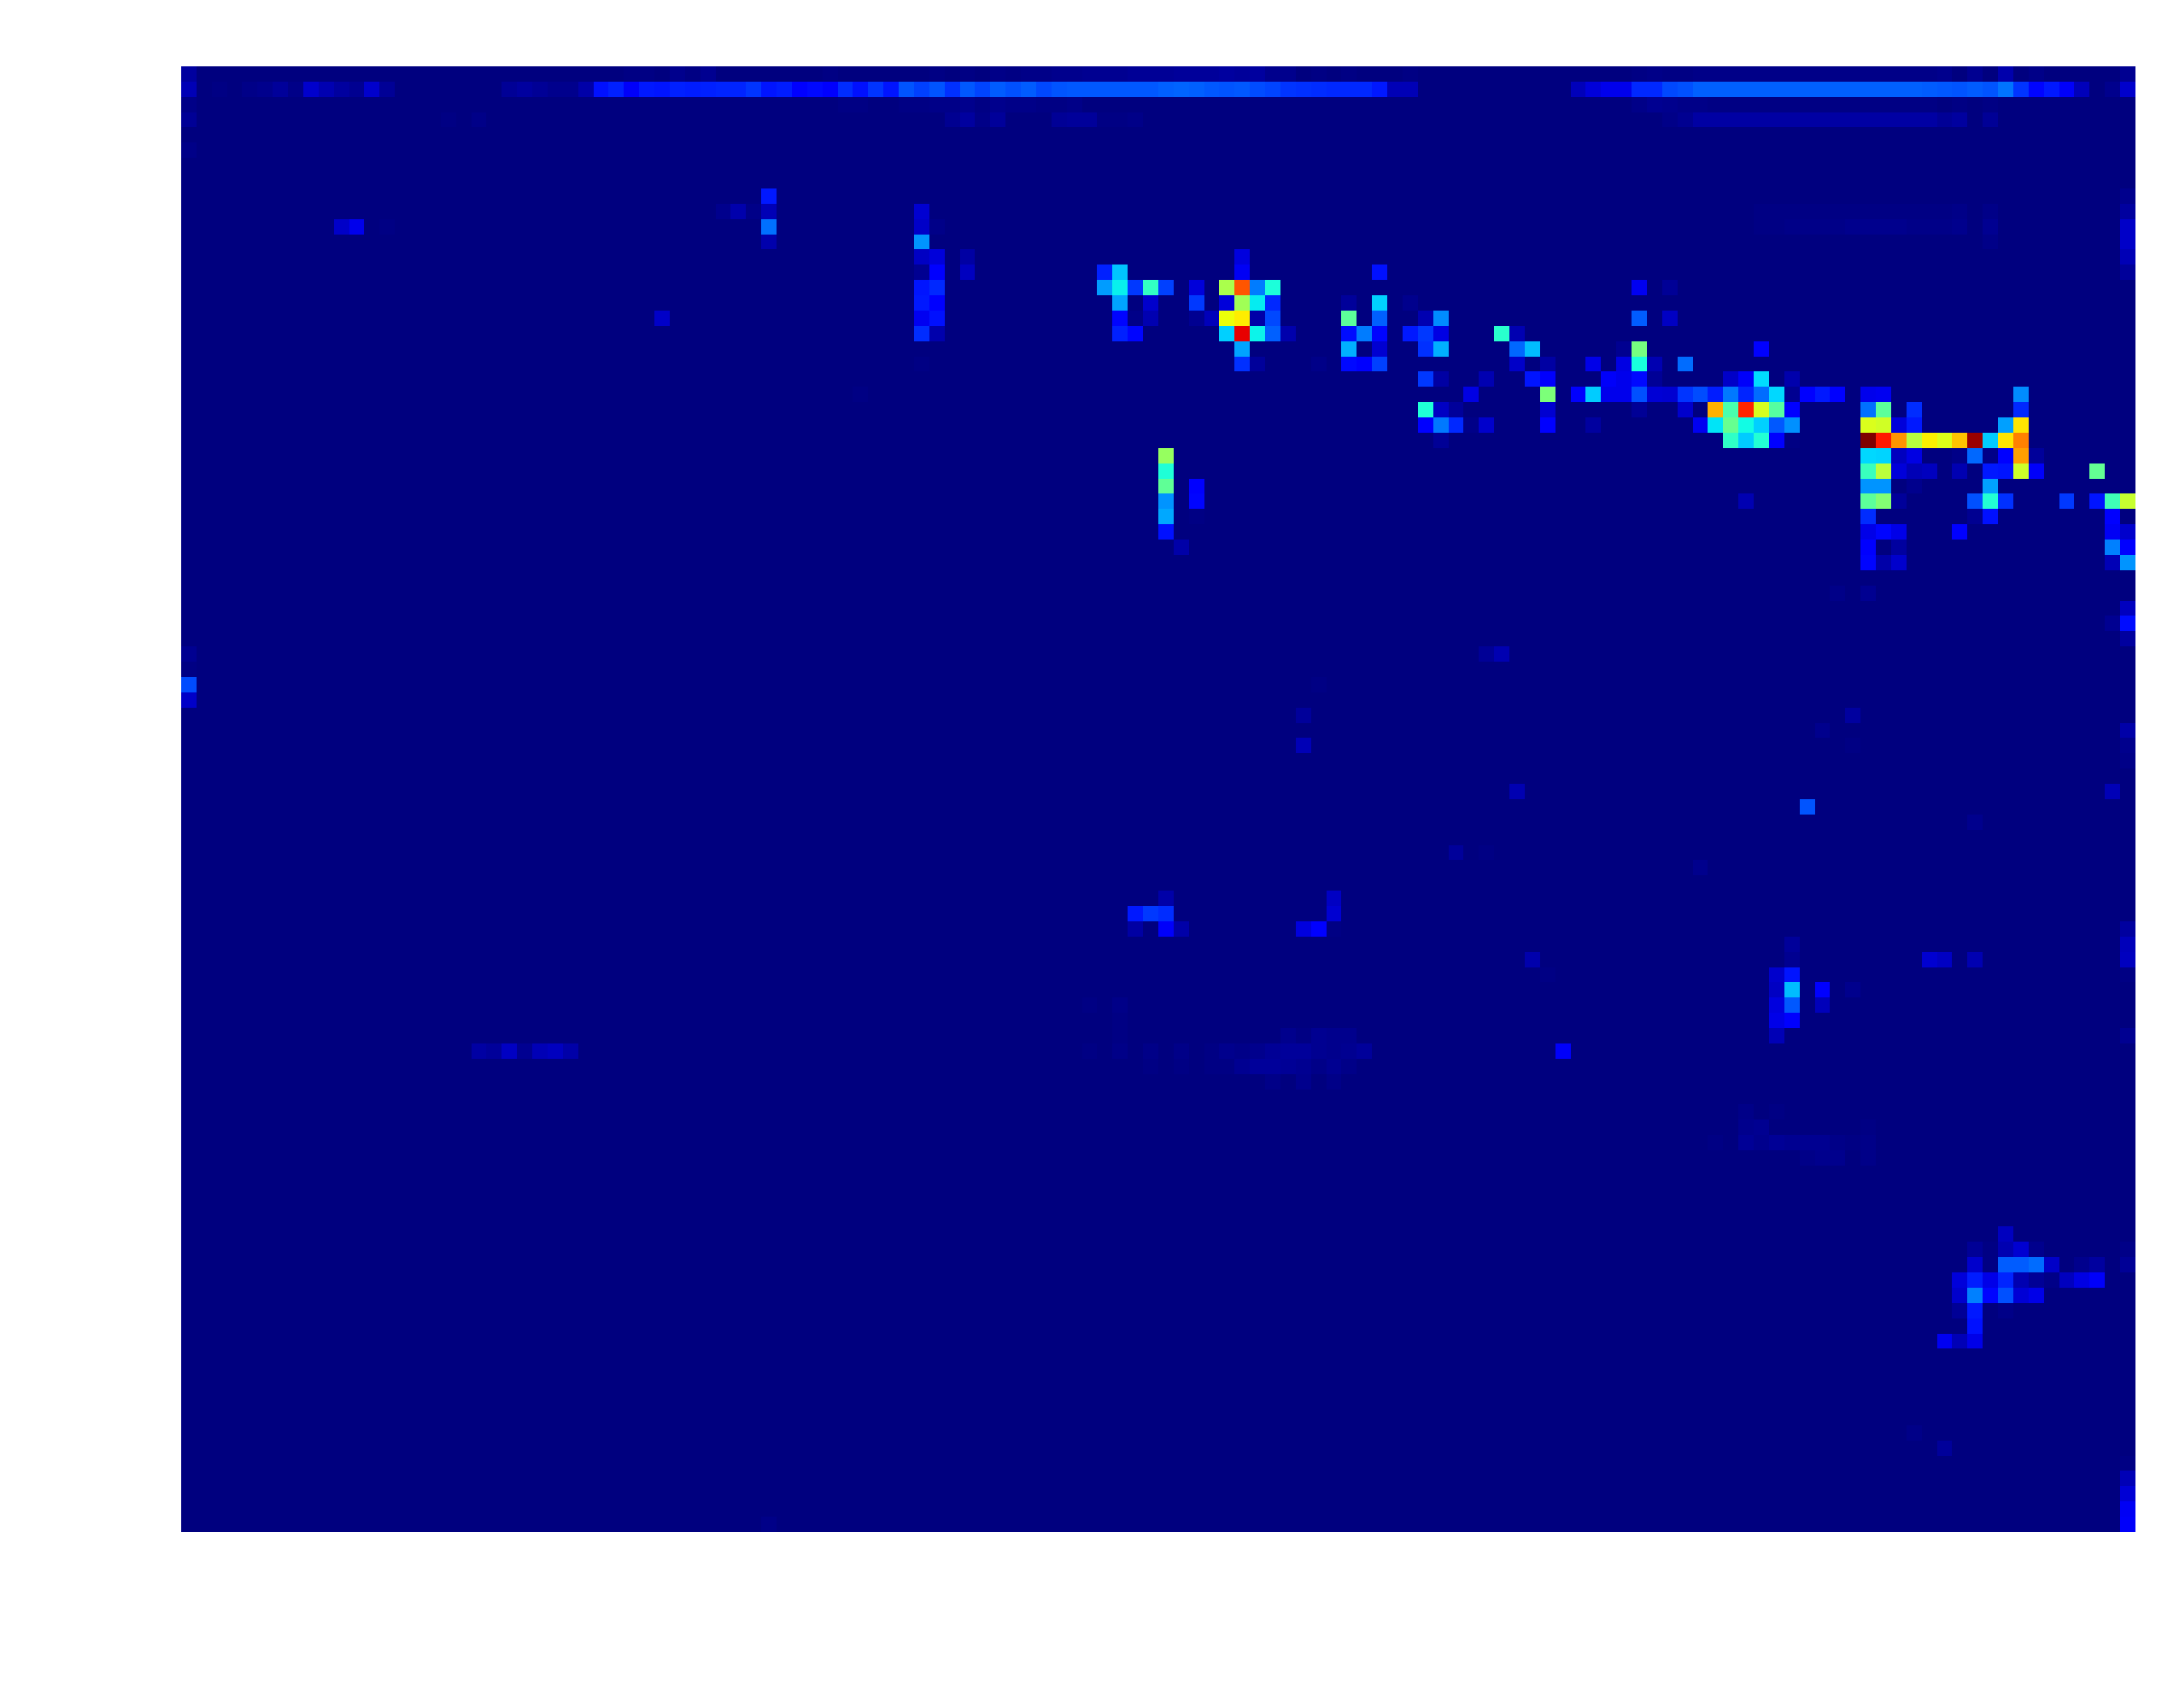

In [49]:
save_density_map(np.squeeze(pred[0], axis=2), "predict.png")

In [50]:
pred[0].shape

(96, 128, 1)

In [51]:
np.savetxt("pred_np.txt",np.squeeze(density_train[0], axis=2))

# Validate data

In [38]:
val_dataset = DatasetSequence(val_img_path, val_density_path, same_size_density=False)

In [ ]:
n = 0
mae = 0
mse = 0
for i in tqdm(range(len(val_dataset))):
    img, density = val_dataset[i]
    # img = preprocess_input(img)
    pred = model.predict(img)
    pred_values = pred.sum()
    truth = density.sum()
    mae = mae + abs(truth - pred_values)
    n += 1
    mse = mse + (truth - pred_values) * (truth - pred_values)

val_result_mae = mae / n
val_result_mse = np.sqrt(mse/n)
print('val mae ', val_result_mae)
print('val mse ', val_result_mse)

# TEST DATA

In [ ]:
test_img_path = get_test_list(TEST_PATH)
test_density_path = create_density_path_list(test_img_path)

In [ ]:
test_dataset = DatasetSequence(test_img_path, test_density_path, same_size_density=False)
# model = load_model(MODEL_PATH)

In [ ]:
n = 0
mae = 0
mse = 0
for i in tqdm(range(len(test_dataset))):
    img, density = test_dataset[i]
    # img = preprocess_input(img)
    pred = model.predict(img)
    pred_values = pred.sum()
    truth = density.sum()
    mae = mae + abs(truth - pred_values)
    n += 1
    mse += (truth - pred_values) * (truth - pred_values)
mae = mae / n
mse = np.sqrt(mse / n)
print(mae)
print(mse)

In [ ]:
# mae = mae / n
# mse = np.sqrt(mse / n)

In [ ]:

# print(mae)
# print(mse)